### Research: how well the photodiode signal correlates with Ed values (interpolated to the Lu response time).

#### Terminology:

**Ed (Downwelling Irradiance)** represents the incoming radiant flux (radiant power) from all directions of the upper hemisphere onto a surface (e.g., the Earth's surface or an object). It includes all the incoming electromagnetic radiation, regardless of the direction. It characterizes the total radiant energy received by a surface.

**Lu (Upwelling Radiance)** characterizes the radiant energy that is reflected or emitted by the surface and travels upward.

**Ld (Downwelling Radiance).** Is a measure of the brightness of the radiation coming from the upper hemisphere towards a specific point on the surface. It provides information about the intensity and directionality of the incoming radiation.

Ed represents the incoming energy,
Ld represents the incoming energy's intensity and directionality, and
Lu represents the outgoing energy from the surface or object.

**Photodiodes** are often used to measure the intensity of light in lux. When light falls on a photodiode, it generates an electrical signal, the strength of which is proportional to the illuminance (lux) of the incident light.

**Photodiode Signal and Reflectance Spectrum.** A light source illuminates a material, and the photodiode measures the intensity of the reflected light at various wavelengths. The resulting photodiode signal is used to create a reflectance spectrum, which provides information about how the material reflects light across the visual spectrum. With the photodiode signal in lux and the photopic data, which typically includes the photopic luminous efficiency function V(λ) as a function of wavelength (λ), we can "weighting" the illuminance measurement to account for the human eye's sensitivity to different wavelengths. This calculation provides a way to convert the measured illuminance into a quantity that represents the perceived brightness of light at that specific wavelength. The result is known as "luminance" or "brightness" at that particular wavelength.

**Hypstar water transfer protocol.**
Ed - Downwelling Irradiance; Ld - Downwelling Radiance; Lu - Upwelling Radiance
Transfer protocol: [Ed 3x] - [Ld 3x] - [Lu 6x] - [Ld 3x] - [Ed 3x]. Sequential measurements.

### Table of contents


#### 1. Load in files
#### 2. Get monitorpd lx windows for each utc from and to pair
#### 3. Observe stdev of monitorpd lx windows, observe ratio of mid to interpolated monitorpd ratios & plot results
<br>
<hr>

#### 1: Load files in

In [37]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import sys
sys.path.append('..\\models')
from helpers import _ltt000027_fsevts_02_photodiode_correlation as _ltt000027

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
from tqdm import tqdm


PATH_TO_DATA = "../data/photodiode/"
PATH_TO_EXPORT = "../data/photodiode/_export/"
PATH_TO_PHOTOPIC = f"{PATH_TO_DATA}photopic.dat"
PATH_TO_HYPERNETS_NC = f"{PATH_TO_DATA}_nc_HYPERNETS_W_LVES_L1B_IRR/"
PATH_TO_MONITORPD_CSV = f"{PATH_TO_DATA}_csv_MONITORPD/"

helper = _ltt000027.Helper()

In [3]:
def get_all_absolute_paths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))


In [4]:
filepaths_csv = [p for p in get_all_absolute_paths("../data/DATA")]

In [ ]:
for filepath in tqdm(filepaths_csv):
    folder_name = filepath.split("\\")[-2]
    shutil.copy2(filepath, f"{PATH_TO_MONITORPD_CSV}{folder_name}.csv")


In [5]:
filepaths_nc = [p for p in get_all_absolute_paths("../data/LVES") if "L1C" in p]

In [ ]:
df_photopic = helper.read_photopic(PATH_TO_PHOTOPIC)
df_photopic_transformed = helper.transform_photopic(df_photopic)
df_photopic_transformed.to_parquet(f"{PATH_TO_EXPORT}_df_photopic_transformed.parquet", index=False)

In [ ]:
dfs_monitorpd = [helper.read_monitorpd(path) for path in helper.get_list_of_files(PATH_TO_MONITORPD_CSV)]
dfs_monitorpd_transformed = [helper.transform_monitorpd(df_) for df_ in dfs_monitorpd]
df_monitorpd_transformed = pd.concat(dfs_monitorpd_transformed, ignore_index=True)
df_monitorpd_transformed = df_monitorpd_transformed.sort_values(by='utc_', ascending=True)
df_monitorpd_transformed.to_parquet(f"{PATH_TO_EXPORT}_df_monitorpd_transformed.parquet", index=False)

In [ ]:
# Ed beginning phase
dfs_transformed_nc = [helper.get_nc_transformed_0(path) for path in filepaths_nc]
df_nc_transform = pd.concat(dfs_transformed_nc, ignore_index=True)
df_nc_transform = df_nc_transform.sort_values(by='utc_', ascending=True)
df_nc_transform.to_parquet(f"{PATH_TO_EXPORT}_df_L1C_nc_transformed.parquet", index=False)

## Use obtained data

In [6]:
df_photopic_transformed = pd.read_parquet(f"{PATH_TO_EXPORT}_df_photopic_transformed.parquet")
df_photopic_transformed

,index,380,385,390,395,400,405,410,415,420,...,735,740,745,750,755,760,765,770,775,780
0,v_lambda_,0.0002,0.000396,0.0008,0.00155,0.0028,0.00466,0.0074,0.0118,0.0175,...,0.000361,0.000249,0.000172,0.00012,0.000085,0.00006,0.000042,0.00003,0.000021,0.000015


In [7]:
wavelen_cols = df_photopic_transformed.select_dtypes(float).columns.tolist()

In [8]:
df_monitorpd_transformed = pd.read_parquet(f"{PATH_TO_EXPORT}_df_monitorpd_transformed.parquet").set_index("utc_")
df_monitorpd_transformed.head(3)

,lx_,lx_inv_
utc_,,
1689915635,20159.0,0.00005
1689915636,20140.8,0.00005
1689915638,20141.6,0.00005


In [9]:
df_l1c = pd.read_parquet(f"{PATH_TO_EXPORT}_df_L1C_nc_transformed.parquet")
df_nc_transform_0 = pd.read_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_0.parquet")
df_nc_transform_1 = pd.read_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_1.parquet")

In [10]:
print(df_l1c.shape, df_nc_transform_0.shape, df_nc_transform_1.shape)

(1044, 752) (1773, 752) (1773, 752)


In [11]:
df_nc_transform_0["utc_to"] = df_nc_transform_1["utc_"]
df_nc_transform_0["utc_from"] = df_nc_transform_0["utc_"]

In [14]:
import numpy as np
# get std of monitorpd lx values from transform_0 utc to transform_1 utc
df_nc_transform_0["utc_to"] = df_nc_transform_1["utc_"]
df_nc_transform_0["utc_from"] = df_nc_transform_0["utc_"]

# align df_l1c so that each value is between utc_to and utc_from
df_nc_transform_0["utc_mid"] = df_nc_transform_0[["utc_from", "utc_to"]] \
    .apply(lambda row: (df_l1c["utc_"] > row["utc_from"]) & (df_l1c["utc_"] < row["utc_to"]), axis=1) \
    .apply(lambda x: np.where(x.values)[0], axis=1) \
    .apply(lambda x: int(x[0]) if len(x) != 0 else np.nan) \
    .apply(lambda x: df_l1c["utc_"].loc[x] if not np.isnan(x) else np.nan)

#### 2: Get lx windows for each from;to pair

In [15]:
df_utc = df_nc_transform_0[["utc_from", "utc_to", "utc_mid"]]

In [16]:
import numpy as np
def get_lx_l1c(row):
    try:
        return df_monitorpd_transformed.loc[int(row["utc_mid"])].lx_
    except:
        return np.nan

def get_lx_seq(row):
    utc_from, utc_to = row["utc_from"], row["utc_to"]
    subdf = df_monitorpd_transformed.loc[utc_from:utc_to].lx_
    return subdf.to_numpy()

In [22]:
df_utc["monitorpd_l1c"] = df_utc.apply(get_lx_l1c, axis=1)
df_utc["monitorpd_seq"] = df_utc.apply(get_lx_seq, axis=1)
df_utc["monitorpd_mid"] = df_utc["monitorpd_seq"].apply(lambda vec: vec[len(vec)//2]) # where monitorpd_l1c is the value obtained via the l1c timestep, monitorpd_mid is simply the middle value of the monitorpd array. We generate this because monitorpd_l1c is missing in some places

##### 2.1: Generate lx metric

In [23]:
df_l1c["lx_l1c"] = df_l1c[wavelen_cols] @ df_photopic_transformed[wavelen_cols].T
df_nc_transform_0["lx_ed0"] = df_nc_transform_0[wavelen_cols] @ df_photopic_transformed[wavelen_cols].T # dot product
df_nc_transform_1["lx_ed1"] = df_nc_transform_1[wavelen_cols] @ df_photopic_transformed[wavelen_cols].T

In [24]:
df_utc["monitorpd_seq_std"] = df_utc["monitorpd_seq"].apply(lambda x: x.std())
df_utc["monitorpd_seq_maxmin"] = df_utc["monitorpd_seq"].apply(lambda x: x.max()-x.min())
df_utc["monitorpd_seq_change"] = df_utc["monitorpd_seq"].apply(lambda x: x[-1]-x[0])

In [25]:
df_utc = df_utc \
    .merge(df_l1c[["utc_", "lx_l1c"]], left_on="utc_mid", right_on="utc_", how="left").drop(columns=["utc_"]) \
    .merge(df_nc_transform_0[["utc_", "lx_ed0"]], left_on="utc_from", right_on="utc_", how="left").drop(columns=["utc_"]) \
    .merge(df_nc_transform_1[["utc_", "lx_ed1"]], left_on="utc_to", right_on="utc_", how="left").drop(columns=["utc_"])

In [27]:
df_utc["lx_ed_interpolated"] = (df_utc["lx_ed0"] + df_utc["lx_ed1"])/2

In [28]:
df_utc

,utc_from,utc_to,utc_mid,monitorpd_l1c,monitorpd_seq,monitorpd_mid,monitorpd_seq_std,monitorpd_seq_maxmin,monitorpd_seq_change,lx_l1c,lx_ed0,lx_ed1,lx_ed_mid,lx_ed_interpolated
0,1689915676,1689915754,1.689916e+09,20502.7,"[20098.5, 20107.6, 20130.8, 20136.6, 20171.5, ...",20491.0,167.005753,600.0,600.0,10311.155500,10288.083922,10340.337894,10314.210908,10314.210908
1,1689916575,1689916652,1.689917e+09,25446.1,"[25260.2, 25232.0, 25260.2, 25256.9, 25286.8, ...",25446.1,55.314376,233.2,41.5,12152.582952,12160.575194,12164.250095,12162.412645,12162.412645
2,1689917475,1689917550,1.689918e+09,27542.7,"[26873.7, 26882.9, 26918.6, 26925.2, 26950.9, ...",27515.3,449.451533,1567.9,1567.9,12669.669446,12661.611588,12693.590911,12677.601249,12677.601249
3,1689918376,1689918452,1.689918e+09,35592.1,"[35610.3, 35629.4, 35622.8, 35640.2, 35645.2, ...",35607.0,189.374924,766.1,-488.0,14455.234912,14576.137043,14358.155693,14467.146368,14467.146368
4,1689919276,1689919350,1.689919e+09,37194.8,"[37216.4, 37189.8, 37184.8, 37184.8, 37155.0, ...",37184.8,62.295371,268.1,-195.1,15562.389364,15737.864637,15435.035716,15586.450176,15586.450176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,1696493784,1696493867,1.696494e+09,6911.4,"[6396.8, 6415.9, 6431.7, 6448.3, 6471.5, 6487....",6903.1,176.299588,644.9,532.9,3361.523900,3244.519199,3468.655093,3356.587146,3356.587146
1769,1696494684,1696494769,1.696495e+09,6121.3,"[6284.8, 6270.7, 6261.5, 6246.6, 6235.0, 6224....",6104.7,172.668813,620.0,408.3,3262.178611,3161.767487,3356.105985,3258.936736,3258.936736
1770,1696495583,1696495666,1.696496e+09,7335.5,"[7311.5, 7311.5, 7305.7, 7300.7, 7299.0, 7298....",7315.6,127.774275,417.5,327.8,3605.098885,3531.334932,3674.535587,3602.935260,3602.935260
1771,1696496483,1696496568,1.696497e+09,6288.9,"[6518.8, 6515.5, 6513.8, 6510.5, 6508.0, 6504....",6308.8,116.515605,341.1,-341.1,2996.269169,3070.892748,2933.065619,3001.979183,3001.979183


##### 2.2: Calculate ed fraction

In [29]:
df_utc["frac_ed_l1c"] = df_utc["lx_l1c"] / df_utc["monitorpd_l1c"]
df_utc["monitorpd_from"] = df_utc["monitorpd_seq"].str[0]
df_utc["monitorpd_to"] = df_utc["monitorpd_seq"].str[-1]
df_utc["frac_ed0"] = df_utc["lx_ed0"] / df_utc["monitorpd_from"]
df_utc["frac_ed1"] = df_utc["lx_ed1"] / df_utc["monitorpd_to"]
df_utc["frac_ed_mid"] = df_utc["lx_ed_interpolated"] / df_utc["monitorpd_mid"]
df_utc["frac_ed_mean"] = (df_utc["frac_ed0"] + df_utc["frac_ed1"])/2
df_utc["frac_mid_mean_ratio"] = df_utc["frac_ed_mid"] / df_utc["frac_ed_mean"]
df_utc["frac_l1c_mean_ratio"] = df_utc["frac_ed_l1c"] / df_utc["frac_ed_mean"]
df_utc["utc_delta"] = df_utc["utc_to"] - df_utc["utc_from"]
df_utc["l1c_excluded"] = df_utc["frac_ed_l1c"].isna()
df_utc["frac_ratio"] = df_utc["frac_ed0"] / df_utc["frac_ed1"]

In [30]:
df_utc = df_utc[["utc_from", "utc_to", "utc_mid", "monitorpd_seq", "lx_l1c", "lx_ed0", "lx_ed1", "frac_ed_l1c", "frac_ed_mid", "frac_ed_mean", "frac_mid_mean_ratio", "frac_l1c_mean_ratio", "frac_ed0", "frac_ed1", "monitorpd_seq_std", "monitorpd_seq_maxmin", "monitorpd_seq_change", "l1c_excluded", "frac_ratio"]]

#### 3: See if ed0 and ed1 relationship affected by lx error metrics

<Axes: >

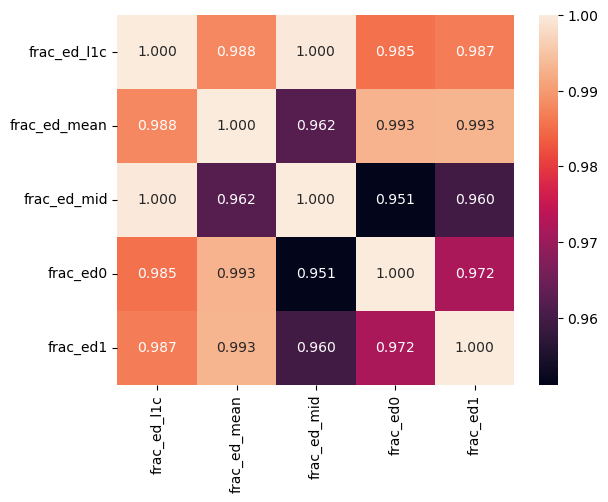

In [40]:
import seaborn as sns
sns.heatmap(df_utc[["frac_ed_l1c", "frac_ed_mean", "frac_ed_mid", "frac_ed0", "frac_ed1"]].corr(), annot=True, fmt=".3f")

In [41]:
df_utc["monitorpd_seq_std"].corr(df_utc["l1c_excluded"])

0.28758942047162867

In [42]:
df_utc.groupby("l1c_excluded")[["monitorpd_seq_std", "monitorpd_seq_maxmin"]].mean()

,monitorpd_seq_std,monitorpd_seq_maxmin
l1c_excluded,,
False,598.137520,2130.751949
True,2393.873802,7743.499465


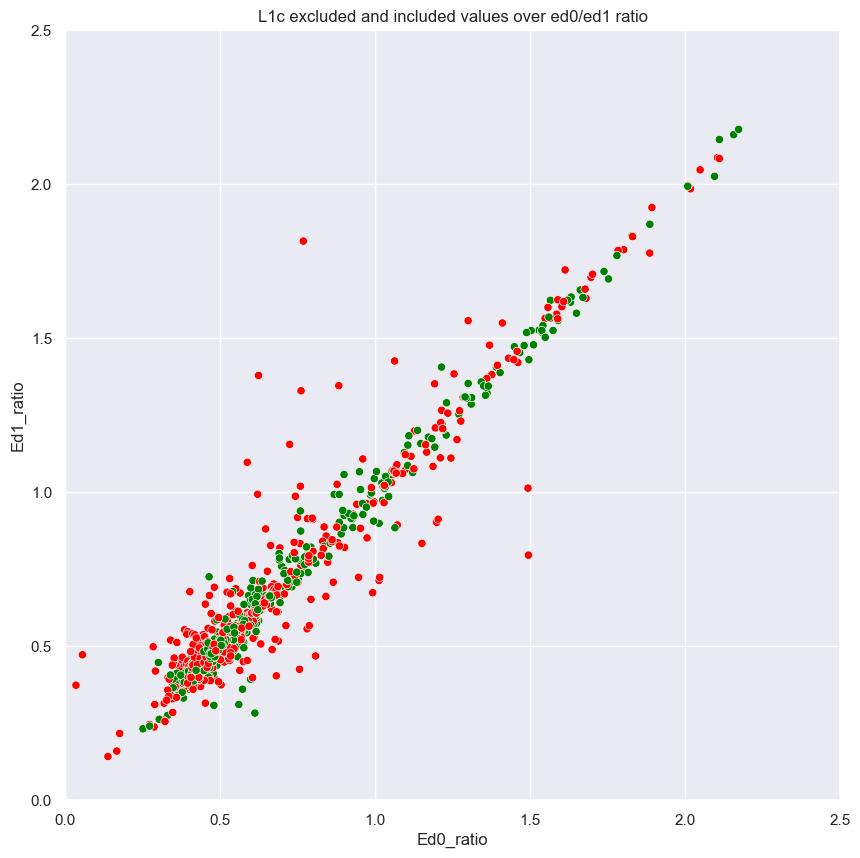

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="darkgrid", palette="bright")
plt.rcParams["figure.figsize"] = (10, 10)
sns.scatterplot(data=df_utc, x="frac_ed0", y="frac_ed1", c=df_utc["l1c_excluded"].map({True: "red", False: "green"}))
plt.title(f"L1c excluded and included values over ed0/ed1 ratio")
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.xlabel('Ed0_ratio')
plt.ylabel('Ed1_ratio')

plt.show()

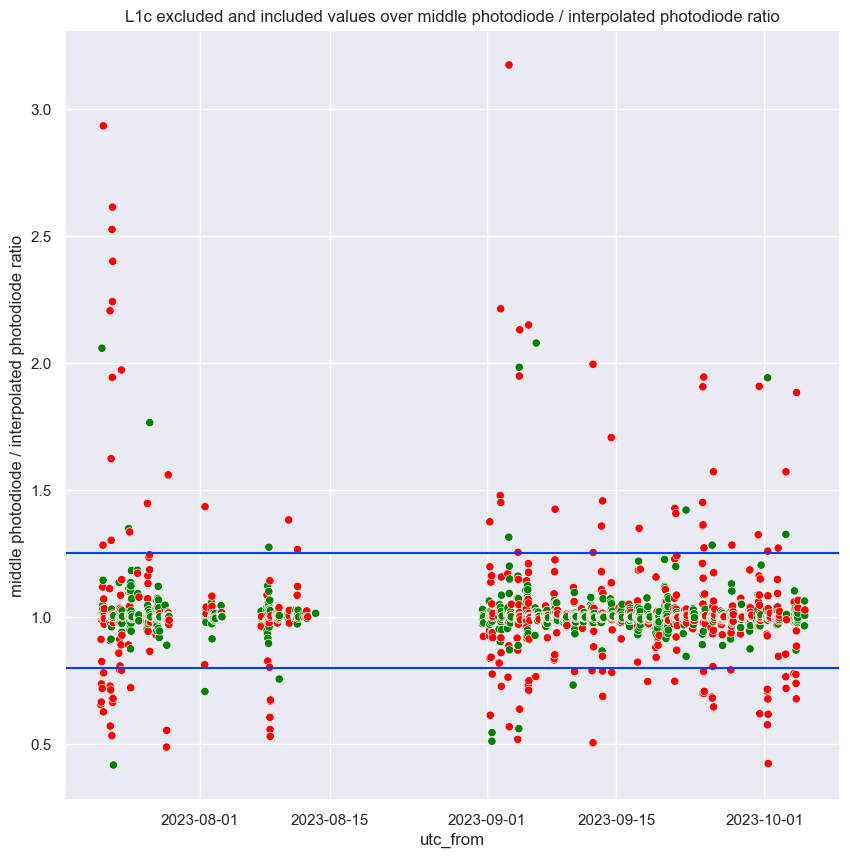

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_utc_used = df_utc.copy() #dropna(subset="frac_l1c_mean_ratio")
df_utc_used["from_dt"] = pd.to_datetime(df_utc_used["utc_from"]*1e9)
sns.set_theme(style="darkgrid", palette="bright")
plt.rcParams["figure.figsize"] = (10, 10)

sns.scatterplot(data=df_utc_used, x="from_dt", y="frac_mid_mean_ratio", c=df_utc_used["l1c_excluded"].map({True: "red", False: "green"}))#df_utc_used["frac_mid_mean_ratio"])#c=df_utc_used["monitorpd_seq_std"])
limits = [4/5, 5/4]
for threshold in limits:
    plt.axhline(threshold)
plt.title(f"L1c excluded and included values over middle photodiode / interpolated photodiode ratio")
# plt.ylim(0, 2.5)
plt.xlabel('utc_from')
plt.ylabel('middle photodiode / interpolated photodiode ratio')

plt.show()

In [54]:
df_utc["frac_mid_mean_positive_ratio"] = df_utc["frac_mid_mean_ratio"].apply(lambda x: max(x, 1/x))

In [55]:
limits = [4/5, 5/4]
df_utc["selected_bad"] = ((df_utc["frac_mid_mean_ratio"] < limits[0]) | (df_utc["frac_mid_mean_ratio"] > limits[1])) & (~df_utc["l1c_excluded"])

In [56]:
df_utc["l1c_excluded_int"] = df_utc["l1c_excluded"].astype(int)

<Axes: xlabel='l1c_excluded_int', ylabel='frac_ratio'>

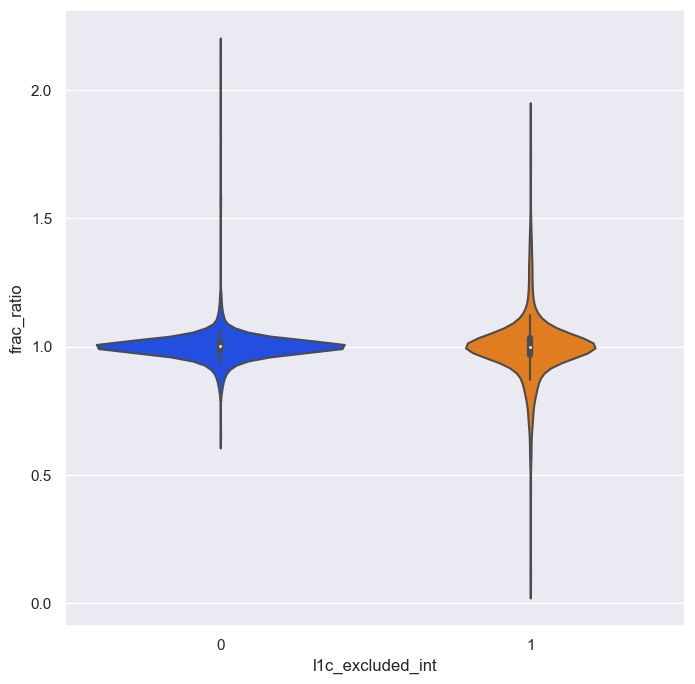

In [57]:
plt.rcParams["figure.figsize"] = (8, 8)
sns.violinplot(data=df_utc, x="l1c_excluded_int", y="frac_ratio")

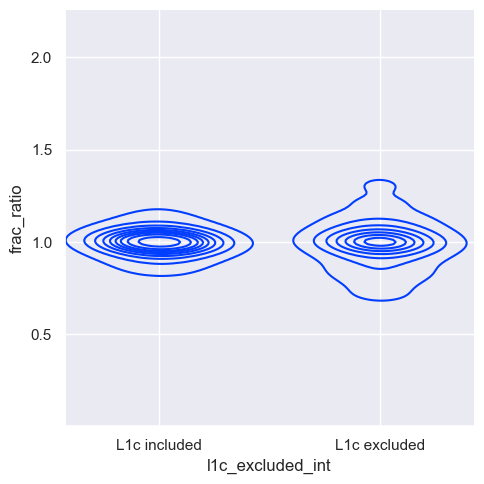

In [58]:
plt.rcParams["figure.figsize"] = (8, 8)
sns.displot(data=df_utc, x="l1c_excluded_int", y="frac_ratio", kind="kde")
plt.xticks([0, 1], ["L1c included", "L1c excluded"])
plt.show()

It seems that the ed0/ed1 ratio is indeed important for including and excluding values in the L1C process, as the std of the frac_ratio in the excluded distribution is much higher, meaning that there are more extreme ed0/ed1 values in the set of excluded timesteps.

In [59]:
df_utc["monitorpd_seq_change_abs"] = df_utc["monitorpd_seq_change"].abs()

In [60]:
df_utc_excluded = df_utc[df_utc["l1c_excluded"]] \
    .head()[["utc_from", "utc_to", "utc_mid", "monitorpd_seq"]]
#.sort_values("monitorpd_seq_std", ascending=False) \
df_utc_included = df_utc[~df_utc["l1c_excluded"]] \
    .head()[["utc_from", "utc_to", "utc_mid", "monitorpd_seq"]]
#.sort_values("monitorpd_seq_std", ascending=True) \
df_utc_included_high_mid_mean_ratio = df_utc \
    [pd.to_datetime(df_utc["utc_from"]*1e9).dt.month < 8] \
    [~df_utc["l1c_excluded"]] \
    .sort_values("frac_mid_mean_positive_ratio", ascending=False) \
    .head()[["utc_from", "utc_to", "utc_mid", "monitorpd_seq"]]
df_utc_included_high_std = df_utc \
    [pd.to_datetime(df_utc["utc_from"]*1e9).dt.month < 8] \
    [~df_utc["l1c_excluded"]] \
    .sort_values("monitorpd_seq_std", ascending=False) \
    .head()[["utc_from", "utc_to", "utc_mid", "monitorpd_seq"]]


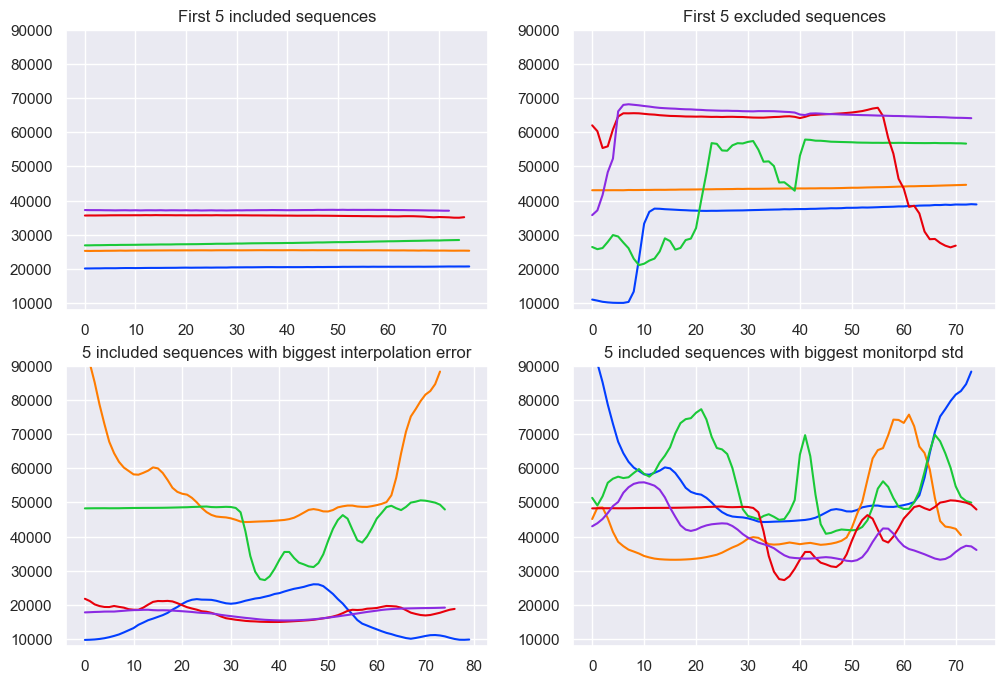

In [75]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

for rownr, row in df_utc_included.iterrows():
    ax1.plot(row["monitorpd_seq"])
ax1.set_ylim(8000, 90000)
ax1.set_title("First 5 included sequences")
for rownr, row in df_utc_excluded.iterrows():
    ax2.plot(row["monitorpd_seq"])
ax2.set_ylim(8000, 90000)
ax2.set_title("First 5 excluded sequences")
for rownr, row in df_utc_included_high_mid_mean_ratio.iterrows():
    ax3.plot(row["monitorpd_seq"])
ax3.set_ylim(8000, 90000)
ax3.set_title("5 included sequences with biggest interpolation error")
for rownr, row in df_utc_included_high_std.iterrows():
    ax4.plot(row["monitorpd_seq"])

ax4.set_ylim(8000, 90000)
ax4.set_title("5 included sequences with biggest monitorpd std")
fig.show()

In [76]:
start_folder = "C:\\Users\\Fedor Stomakhin\\Downloads\\waterhypernet\\hypstar\\processed20230317\\LVES\\2023"

In [77]:
start_folder

'C:\\Users\\Fedor Stomakhin\\Downloads\\waterhypernet\\hypstar\\processed20230317\\LVES\\2023'

In [78]:
def filename_to_datetime(fname):
    return pd.to_datetime(fname.split("IMG_")[1].split("_")[0])
print(filename_to_datetime("HYPERNETS_W_LVES_IMG_20230506T0502_20230509T0031_006_140_-135_v1.0.jpg"))

2023-05-06 05:02:00


In [79]:
def generate_datetime(df):
    df["utc_from_dt"] = pd.to_datetime(df["utc_from"]*1e9).dt.floor('h')
    df["utc_to_dt"] = pd.to_datetime(df["utc_to"]*1e9).dt.ceil('h')

In [80]:
for df in [df_utc_excluded, df_utc_included, df_utc_included_high_std, df_utc_included_high_mid_mean_ratio]:
    generate_datetime(df)

In [81]:
def included_filename(row: dict, fname: str):
    dt = filename_to_datetime(fname)
    return (dt >= row["utc_from_dt"]) and (dt <= row["utc_to_dt"])

In [82]:
image_paths = [path for path in get_all_absolute_paths(start_folder) if (".jpg" in path) and ("140_-135" in path)]

In [83]:
from PIL import Image

In [84]:
len(image_paths)

6839

In [95]:
row_idx_to_file = {}
for row_idx, row in df_utc_excluded.iterrows():
    filtered = list(filter(lambda x: included_filename(row, x), image_paths))
    top_5_files = filtered[:5]
    row_idx_to_file[row_idx] = top_5_files
    #print(len(filtered), filtered)

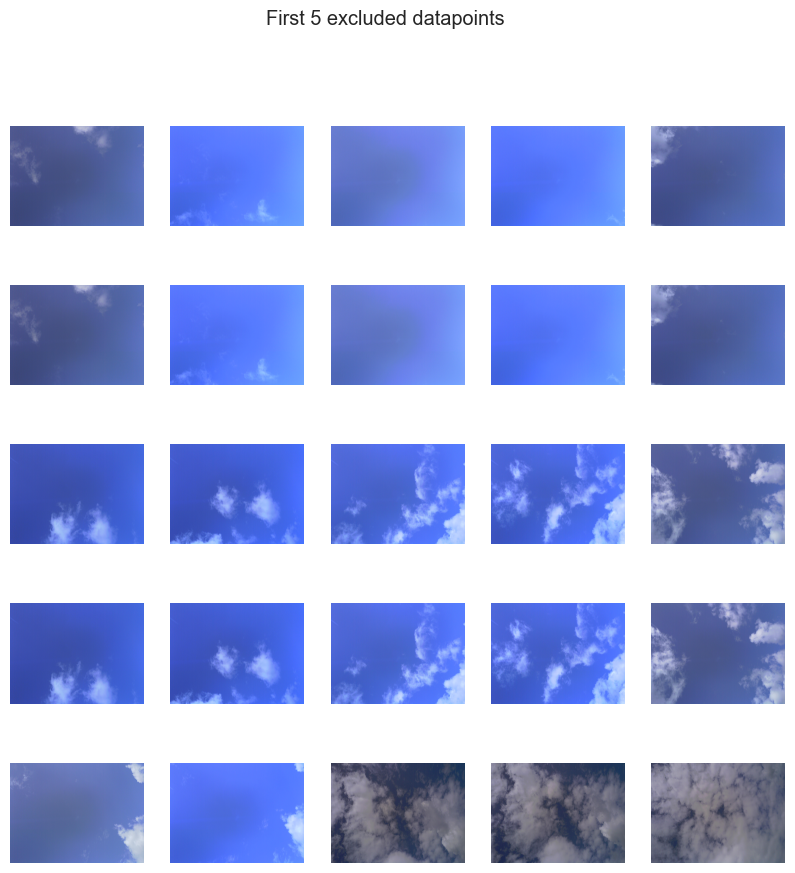

In [96]:
f, axarr = plt.subplots(5,5, figsize=(10, 10))
plt.axis("off")
plt.rcParams['axes.grid'] = False

ax_idx = 0
for row_idx, row in df_utc_excluded.iterrows():
    for col_idx, img_path in enumerate(row_idx_to_file[row_idx]):
        img = Image.open(img_path)
        ax = axarr[ax_idx, col_idx]
        ax.tick_params(which = "both", left = False, right = False , labelleft = False ,
                                           labelbottom = False, bottom = False, )
        ax.axis('off')
        ax.grid(False)
        ax.imshow(img)
    ax_idx += 1
plt.suptitle("First 5 excluded datapoints")
plt.show()
plt.rcParams['axes.grid'] = True

In [87]:
row_idx_to_file = {}
for row_idx, row in df_utc_included.iterrows():
    filtered = list(filter(lambda x: included_filename(row, x), image_paths))
    top_5_files = filtered[:5]
    row_idx_to_file[row_idx] = top_5_files
    #print(len(filtered), filtered)

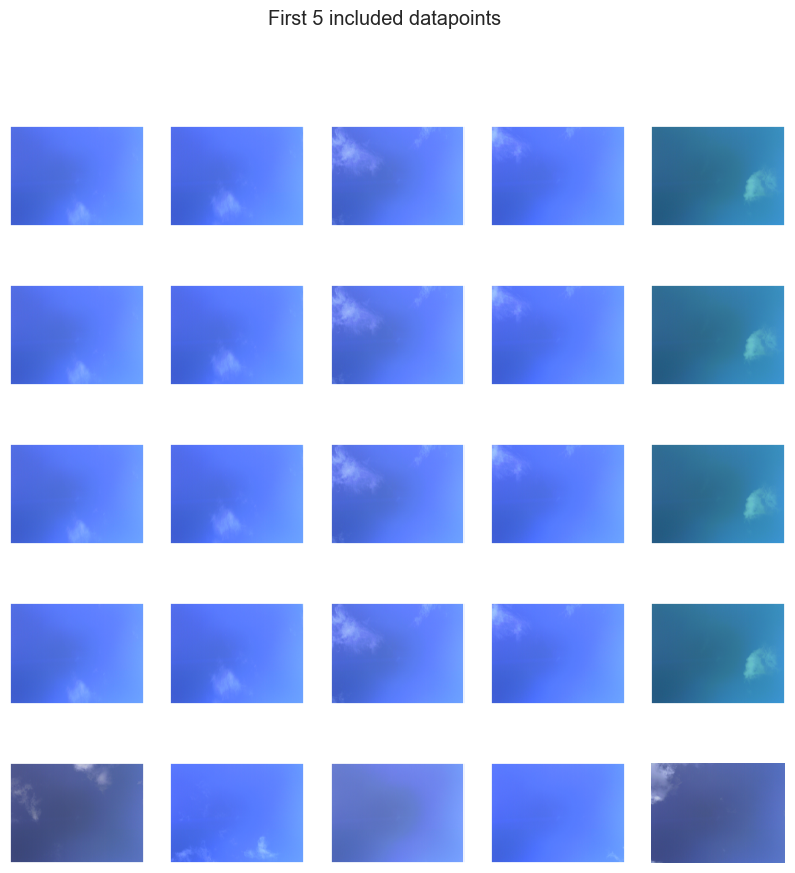

In [88]:
f, axarr = plt.subplots(5,5, figsize=(10, 10))
plt.axis("off")
plt.rcParams['axes.grid'] = False

ax_idx = 0
for row_idx, row in df_utc_included.iterrows():
    for col_idx, img_path in enumerate(row_idx_to_file[row_idx]):
        img = Image.open(img_path)
        axarr[ax_idx, col_idx].imshow(img)
        axarr[ax_idx, col_idx].tick_params(which = "both", left = False, right = False , labelleft = False ,
                                           labelbottom = False, bottom = False, )
        axarr[ax_idx, col_idx].grid(False)
    ax_idx += 1
plt.suptitle("First 5 included datapoints")
plt.show()
plt.rcParams['axes.grid'] = True

In [89]:
row_idx_to_file = {}
for row_idx, row in df_utc_included_high_mid_mean_ratio.iterrows():
    filtered = list(filter(lambda x: included_filename(row, x), image_paths))
    top_5_files = filtered[:5]
    row_idx_to_file[row_idx] = top_5_files
    #print(len(filtered), filtered)

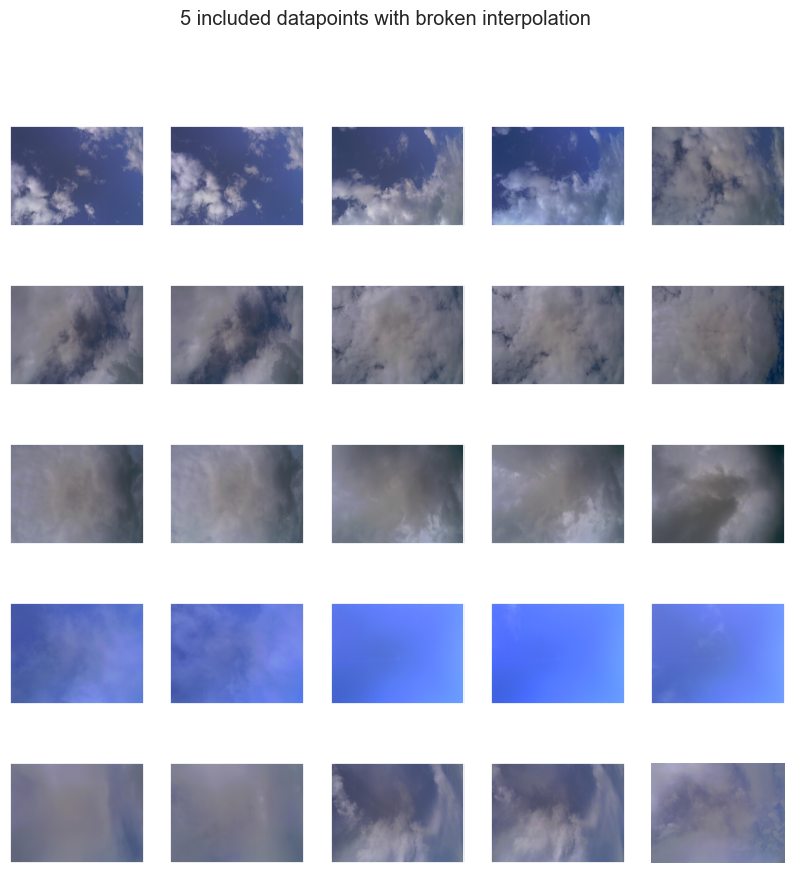

In [90]:
f, axarr = plt.subplots(5,5, figsize=(10, 10))
plt.axis("off")
plt.rcParams['axes.grid'] = False

ax_idx = 0
for row_idx, row in df_utc_included_high_mid_mean_ratio.iterrows():
    for col_idx, img_path in enumerate(row_idx_to_file[row_idx]):
        img = Image.open(img_path)
        axarr[ax_idx, col_idx].imshow(img)
        axarr[ax_idx, col_idx].tick_params(which = "both", left = False, right = False , labelleft = False ,
                                           labelbottom = False, bottom = False, )
        axarr[ax_idx, col_idx].grid(False)
    ax_idx += 1
plt.suptitle("5 included datapoints with broken interpolation")
plt.show()
plt.rcParams['axes.grid'] = True

In [91]:
row_idx_to_file = {}
for row_idx, row in df_utc_included_high_std.iterrows():
    filtered = list(filter(lambda x: included_filename(row, x), image_paths))
    top_5_files = filtered[:5]
    row_idx_to_file[row_idx] = top_5_files
    #print(len(filtered), filtered)

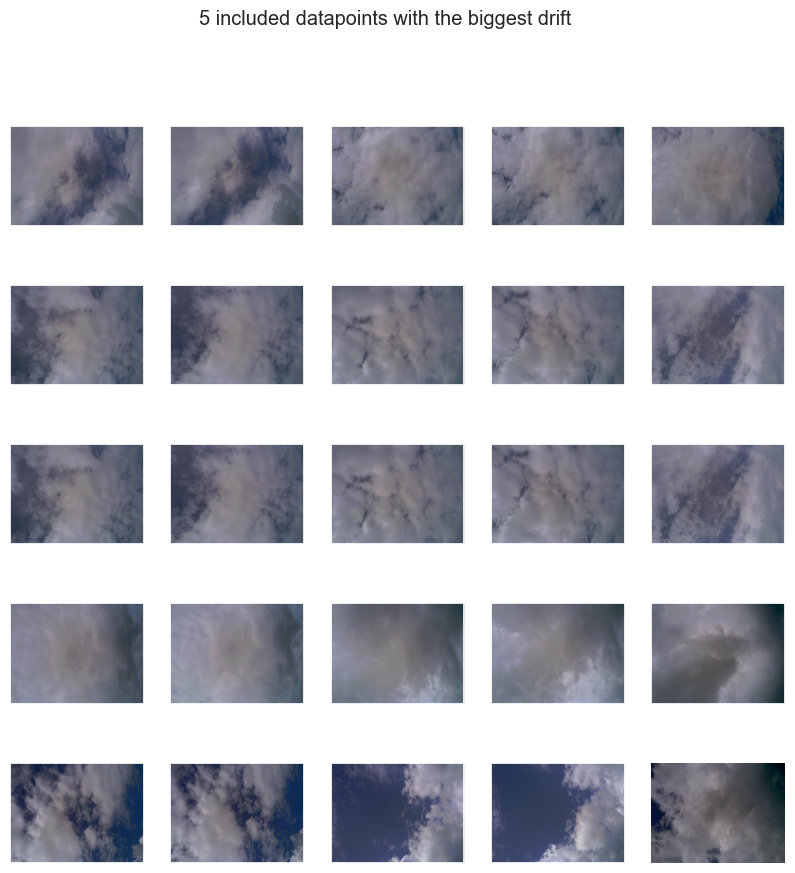

In [92]:
f, axarr = plt.subplots(5,5, figsize=(10, 10))
plt.axis("off")
plt.rcParams['axes.grid'] = False

ax_idx = 0
for row_idx, row in df_utc_included_high_std.iterrows():
    for col_idx, img_path in enumerate(row_idx_to_file[row_idx]):
        img = Image.open(img_path)
        axarr[ax_idx, col_idx].imshow(img)
        axarr[ax_idx, col_idx].tick_params(which = "both", left = False, right = False , labelleft = False ,
                                           labelbottom = False, bottom = False, )
        axarr[ax_idx, col_idx].grid(False)
    ax_idx += 1
plt.suptitle("5 included datapoints with the biggest drift")
plt.show()
plt.rcParams['axes.grid'] = True